# Section 1


In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.5.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.1
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


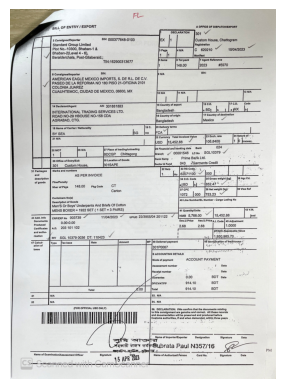

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/drive/MyDrive/SECTRUM/easy_ocr/prime bank ltdn_11.jpg'

image = mpimg.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
!pip install transformers

In [ ]:
 pip install transformers[sentencepiece]

In [ ]:
!pip install --upgrade transformers

In [ ]:
import torch
from transformers import DonutProcessor, VisionEncoderDecoderModel

# Install SentencePiece library
!pip install sentencepiece

# Initialize and load the Donut model and processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

# Choose the appropriate device (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move the model to the chosen device
model.to(device)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [ ]:
%%time
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 2560, 1920])
CPU times: user 477 ms, sys: 0 ns, total: 477 ms
Wall time: 479 ms


In [ ]:

task_prompt = "<s_docvqa><s_question>{user_input}</s_question><s_answer>"
question = "When is the coffee break?"
prompt = task_prompt.replace("{user_input}", question)

# prompts = [prompt,
#            "<s_docvqa><s_question>When is council meeting?</s_question><s_answer>",
#           ]
prompts = [
           "<s_docvqa><s_question>What is an asset of the Nation?</s_question><s_answer>",
          ]

decoder_input_ids = processor.tokenizer(prompts, add_special_tokens=False, padding=True, return_tensors="pt")["input_ids"]



outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True)

In [ ]:
import re

seq = processor.batch_decode(outputs.sequences)[0]
seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
print(seq)

<s_question> What is an asset of the Nation?</s_question><s_answer> california</s_answer>


In [ ]:

processor.token2json(seq)

{'question': 'What is an asset of the Nation?', 'answer': 'california'}

In [ ]:
processor.batch_decode(outputs.sequences)

['<s_docvqa><s_question> What is an asset of the Nation?</s_question><s_answer> california</s_answer></s>']

In [ ]:
outputs

GreedySearchEncoderDecoderOutput(sequences=tensor([[57527, 57529, 42543, 52743,  9971, 54915, 44236,  2587, 48941, 52917,
         36209, 57524, 57526, 50133, 31744,  4379, 57523,     2]]), scores=(tensor([[ 7.5788, -4.9467, 20.8921,  ...,  1.1030, 10.5482,  5.2336]]), tensor([[12.4326, -3.5825, 32.8020,  ...,  3.8711, 16.6949, -0.2996]]), tensor([[ 9.1756, -2.6899, 20.8051,  ...,  2.3434, 13.2839,  1.2831]]), tensor([[-17.8120,  -6.8165, -11.1799,  ...,   0.6427, -16.4849,   3.1083]]), tensor([[ 62.9046,  -1.2695, 109.7854,  ...,   4.3429,  58.3966,  -2.2714]])), encoder_attentions=None, encoder_hidden_states=None, decoder_attentions=None, cross_attentions=None, decoder_hidden_states=None)

In [ ]:
def get_outputs(image, questions):
    pixel_values = processor(image, return_tensors="pt").pixel_values
    print(pixel_values.shape)

    prompts = []
    for q in questions:
        prompts.append(f"<s_docvqa><s_question>{q}</s_question><s_answer>")
    print(prompts)

    decoder_input_ids = processor.tokenizer(prompts, add_special_tokens=False, padding=True, return_tensors="pt")["input_ids"]

    outputs = model.generate(pixel_values.to(device),
                                   decoder_input_ids=decoder_input_ids.to(device),
                                   max_length=model.decoder.config.max_position_embeddings,
                                   early_stopping=True,
                                   pad_token_id=processor.tokenizer.pad_token_id,
                                   eos_token_id=processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,
                                   output_scores=True)

    return processor.batch_decode(outputs.sequences)

def preprocess_outputs(outputs):
    l = []
    for o in outputs:
        seq = o.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
        seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
        l.append(processor.token2json(seq))
    return l



In [ ]:
from PIL import Image
image_1 = Image.open('/content/drive/MyDrive/SECTRUM/easy_ocr/prime bank ltdn_1.jpg').convert("RGB")

In [ ]:
import numpy as np
image__ = np.array(image_1)
image__.shape

(3840, 2716, 3)

In [ ]:
image_1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
qs = ['Who is the Customer?',
      'What is the LC Number?',
      'what is the Our Bill No?',
      'What is the Branch?']

o = get_outputs(image_1, qs)

torch.Size([1, 3, 2560, 1920])
['<s_docvqa><s_question>Who is the Customer?</s_question><s_answer>', '<s_docvqa><s_question>What is the LC Number?</s_question><s_answer>', '<s_docvqa><s_question>what is the Our Bill No?</s_question><s_answer>', '<s_docvqa><s_question>What is the Branch?</s_question><s_answer>']


In [ ]:
preprocess_outputs(o)

[{'question': 'Who is the Customer?', 'answer': 'datails'},
 {'question': 'What is the LC Number?', 'answer': 'sgll0379'},
 {'question': 'what is the Our Bill No?', 'answer': '902.10.i.gb'},
 {'question': 'What is the Branch?', 'answer': '16.05.2023'}]

# Section 2


In [ ]:
!pip install PyMuPDF
!pip install Pillow


In [ ]:
import fitz  # import the bindings
doc = fitz.open('/content/drive/MyDrive/SECTRUM/easy_ocr/Prime Bank Limited 27.pdf')  # open document
# for page in doc:  # iterate through the pages
#     pix = page.get_pixmap()  # render page to an image
#     pix.save(f'test_pages/ADM_10K_page{page.number}.png' )  # store image as a PNG


In [ ]:
# page_num = 43
page_num = 0

pix = doc[page_num].get_pixmap()  # render page to an image
pix.save(f'Prime Bank Limited 27{page_num+1}.png' )  # store image as a PNG

In [ ]:
from PIL import Image
img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)

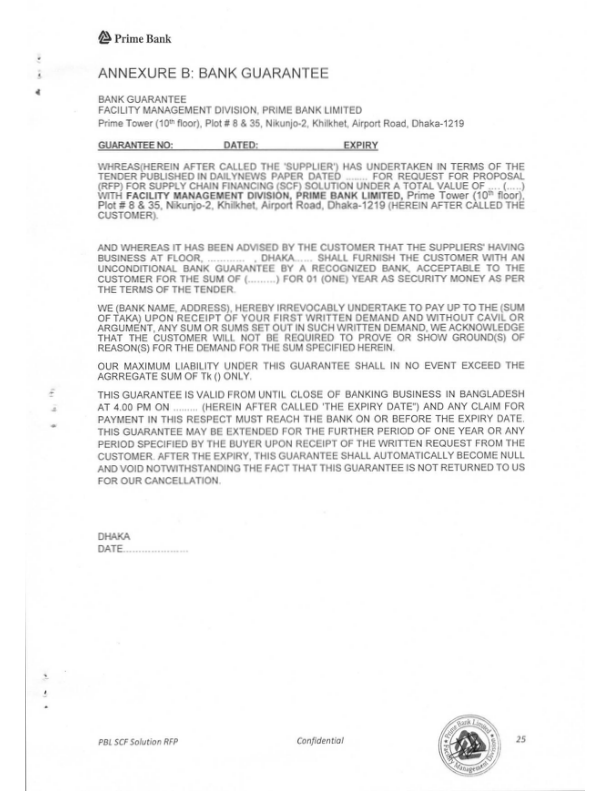

In [ ]:
img

In [ ]:
qs = [
      # 'What is the Address?',
    # 'What is the Earnings Before Income Taxes in 2021?',
    # 'What is the Net Earnings Including Noncontrolling Interests in 2019?'
      # 'What is the Revenue in 2020?',
      # 'What is the Revenue in 2021?',
    # 'What is the name at the top of exact name of registrant?',
    # 'What is the address at the top of address of principal?',
     'What is the Road?',
]
o = get_outputs(img, qs)

torch.Size([1, 3, 2560, 1920])
['<s_docvqa><s_question>What is the Road?</s_question><s_answer>']


In [ ]:
%%time
o = get_outputs(img, qs)

torch.Size([1, 3, 2560, 1920])
['<s_docvqa><s_question>What is the Road?</s_question><s_answer>']
CPU times: user 1min 7s, sys: 22.1 s, total: 1min 29s
Wall time: 1min 33s


In [ ]:
%%time
preprocess_outputs(o)

CPU times: user 86.1 ms, sys: 3.11 ms, total: 89.2 ms
Wall time: 89.2 ms


[{'question': 'What is the Road?', 'answer': 'dhaka-1219'}]